## Cluster Analytics


### Import Libraries

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, pi
from datetime import datetime

### Load datasets 

In [27]:
# Load datasets
charging_sessions_data = pd.read_csv("cleaned_data.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

In [28]:
# Convert the 'timestamp' column in weather_data to datetime format
weather_data["timestamp"] = pd.to_datetime(weather_data["timestamp"])

# Extract date from 'connectionTime' in charging_sessions_data
charging_sessions_data["date"] = pd.to_datetime(charging_sessions_data["connectionTime"]).dt.date
weather_data["date"] = weather_data["timestamp"].dt.date

# Merge weather data into charging_sessions_data on the 'date' column
charging_sessions_data = charging_sessions_data.merge(
    weather_data[["date", "temperature", "precipitation"]],
    on="date",
    how="left"
)

# Check the merged dataset
print(charging_sessions_data.head())

# Data Preprocessing
## Calculate session metrics
charging_sessions_data["session_duration"] = (
    pd.to_datetime(charging_sessions_data["disconnectTime"]) - pd.to_datetime(charging_sessions_data["connectionTime"])
).dt.total_seconds() / 3600

charging_sessions_data["idle_time"] = (
    pd.to_datetime(charging_sessions_data["disconnectTime"]) - pd.to_datetime(charging_sessions_data["doneChargingTime"])
).dt.total_seconds() / 3600

charging_sessions_data["energy_ratio"] = (
    charging_sessions_data["kWhDelivered"] / charging_sessions_data["kWhRequested"]
)

# Add time-based features
charging_sessions_data["hour"] = pd.to_datetime(charging_sessions_data["connectionTime"]).dt.hour
charging_sessions_data["hour_sin"] = charging_sessions_data["hour"].apply(lambda x: sin(2 * pi * x / 24))
charging_sessions_data["hour_cos"] = charging_sessions_data["hour"].apply(lambda x: cos(2 * pi * x / 24))
charging_sessions_data["weekday"] = pd.to_datetime(charging_sessions_data["connectionTime"]).dt.weekday


                         id             connectionTime  \
0  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
1  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
2  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
3  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
4  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   

              disconnectTime           doneChargingTime  kWhDelivered  \
0  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
1  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
2  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
3  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
4  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   

                                sessionID  siteID  spaceID    stationID  \
0  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-1-179-810   
1  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-

### Feature Selection and Data Scaling

In [29]:
# Feature Selection
features = charging_sessions_data[
    ["session_duration", "idle_time", "energy_ratio", "hour_sin", "hour_cos", "kWhDelivered", "temperature", "precipitation"]
]
features = features.fillna(0)

# Data Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### Elbow Method

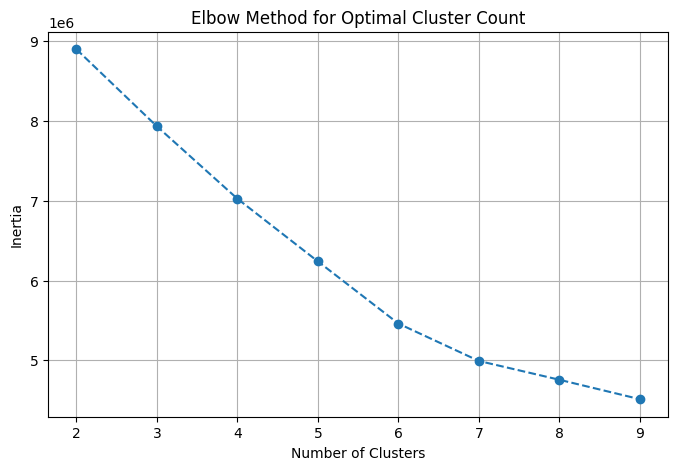

In [30]:
# Elbow Method for optimal clusters
inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o", linestyle="--")
plt.title("Elbow Method for Optimal Cluster Count")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()



The chart represents the Elbow Method for determining the optimal number of clusters. The line, which plots inertia (the sum of squared distances within clusters) against the cluster count, drops sharply and then clearly levels off around 5 to 6 clusters. This distinct “elbow” point indicates that 5 or 6 clusters likely strike the best balance between capturing meaningful structure in the data and avoiding unnecessary complexity

### PCA for visualization

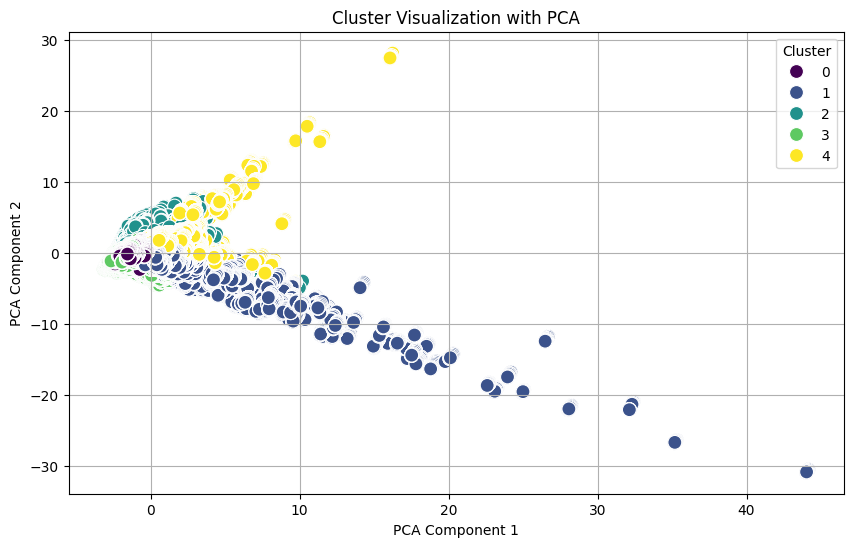

In [31]:
# Clustering with optimal number of clusters (e.g., 5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
charging_sessions_data["cluster"] = kmeans.fit_predict(scaled_features)

# PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Scatterplot for PCA visualization of clusters
plt.figure(figsize=(10, 6))  # Increase plot size
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=charging_sessions_data["cluster"],
    palette="viridis",
    s=100
)
plt.title("Cluster Visualization with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right")  # Specify a fixed legend location
plt.grid()
plt.show()

This scatter plot provides a two-dimensional visualization of the data after applying Principal Component Analysis (PCA). Each color represents a distinct cluster (labeled 0 through 4), and we can see clear groupings in the PCA-transformed space. The fact that these clusters appear relatively well-separated suggests that the chosen clustering approach has effectively captured meaningful differences within the dataset.

### Cluster Summarization

In [32]:
# Cluster Summarization
cluster_summary = charging_sessions_data.groupby("cluster").agg(
    avg_session_duration=("session_duration", "mean"),
    avg_idle_time=("idle_time", "mean"),
    avg_energy_ratio=("energy_ratio", "mean"),
    avg_kWhDelivered=("kWhDelivered", "mean"),
    avg_temperature=("temperature", "mean"),
    avg_precipitation=("precipitation", "mean"),
    session_count=("cluster", "size")
)

# Display cluster summary
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         avg_session_duration  avg_idle_time  avg_energy_ratio  \
cluster                                                          
0                    4.151887       1.344377          0.530775   
1                    9.732204       5.931253          0.606795   
2                    6.994668       3.345014          0.619766   
3                    3.268111       1.216817          0.513104   
4                    8.987540       2.053075          0.871711   

         avg_kWhDelivered  avg_temperature  avg_precipitation  session_count  
cluster                                                                       
0                7.532969        18.509134           0.021079         455955  
1                9.477364        17.304624           0.027981         515820  
2               12.154357        11.320549           4.864581          10273  
3                7.929963        18.739527           0.022796         206003  
4               33.109935        16.047323    

C:\Users\sk212\AppData\Local\Temp\ipykernel_17304\2439072895.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


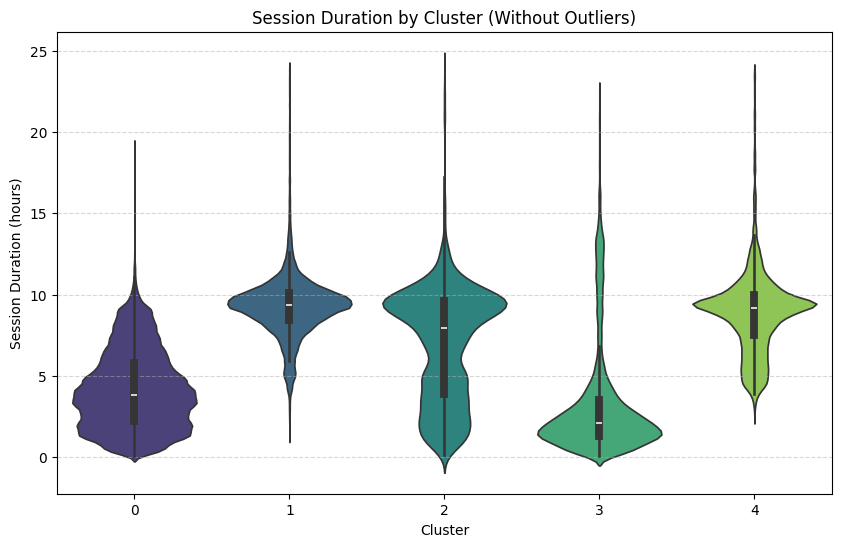

In [33]:
# Filter out outliers (optional, adjust threshold as needed)
threshold = 24  # Max session duration in hours for filtering
filtered_data = charging_sessions_data[charging_sessions_data["session_duration"] <= threshold]

# Create a violin plot without logarithmic scale
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="cluster",
    y="session_duration",
    data=filtered_data,  # Use filtered data to exclude outliers
    inner="box",  # Adds boxplot inside the violin plot
    palette="viridis"
)

# Add titles and labels
plt.title("Session Duration by Cluster (Without Outliers)")
plt.xlabel("Cluster")
plt.ylabel("Session Duration (hours)")

# Add grid lines for clarity
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show the plot
plt.show()

These violin plots illustrate the distribution of session durations (in hours) for each cluster, with obvious outliers removed. We can see that Cluster 0 tends to have shorter sessions, whereas Cluster 2 shows a wider range and a higher median. The box shapes inside each “violin” represent the standard boxplot statistics (median and interquartile range), while the outer shape reflects the distribution of the data. Overall, the plots make it clear that the clusters differ significantly in both their average and maximum session durations.

### Heatmap for temporal and spatial trends

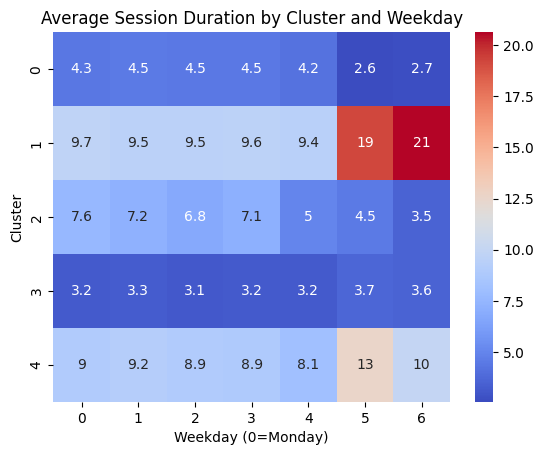

In [34]:
# Heatmap for temporal and spatial trends
time_series = charging_sessions_data.groupby(["cluster", "weekday"])["session_duration"].mean().unstack()
sns.heatmap(time_series, cmap="coolwarm", annot=True)
plt.title("Average Session Duration by Cluster and Weekday")
plt.xlabel("Weekday (0=Monday)")
plt.ylabel("Cluster")
plt.show()

This heatmap illustrates the average session duration (in hours) by weekday (0=Monday) and cluster, with blue indicating shorter and red indicating longer durations. Notably, Cluster 1 has very long sessions on weekends, while others (like Cluster 0) drop significantly. Cluster 2 remains in a mid-range, Cluster 3 consistently shows low values, and Cluster 4 spikes on Saturday. Overall, the chart highlights how usage varies by weekday and cluster

### Time series analysis 

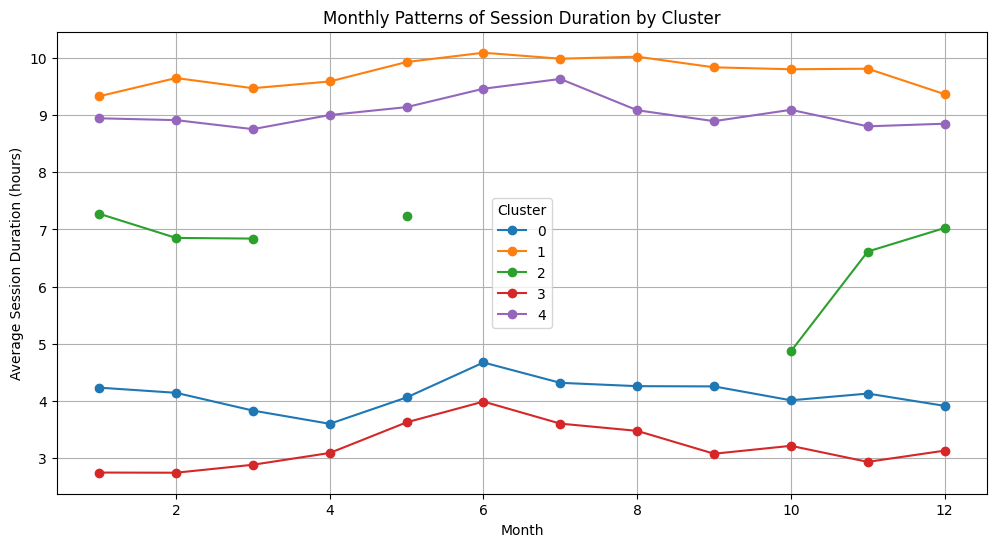

In [35]:
# Time series analysis for seasonal patterns
charging_sessions_data["month"] = pd.to_datetime(charging_sessions_data["connectionTime"]).dt.month
monthly_patterns = charging_sessions_data.groupby(["month", "cluster"])["session_duration"].mean().unstack()

monthly_patterns.plot(kind="line", figsize=(12, 6), marker="o")
plt.title("Monthly Patterns of Session Duration by Cluster")
plt.xlabel("Month")
plt.ylabel("Average Session Duration (hours)")
plt.grid()
plt.legend(title="Cluster")
plt.show()


This line chart displays the monthly trends in average session duration (in hours) for each cluster. Cluster 1 (orange) consistently leads with about 9–10 hours throughout the year, followed by Cluster 4 (purple), which also shows relatively high values. Cluster 2 (green) starts at a moderate level but rises significantly in the fall. Cluster 0 (blue) remains mostly in the mid-range (about 4–5 hours), while Cluster 3 (red) consistently has the lowest duration (around 3 hours). Overall, the lines make it clear that usage patterns vary considerably by cluster over the course of the year.

### Normalize data for meaningful comparison

<Figure size 1200x800 with 0 Axes>

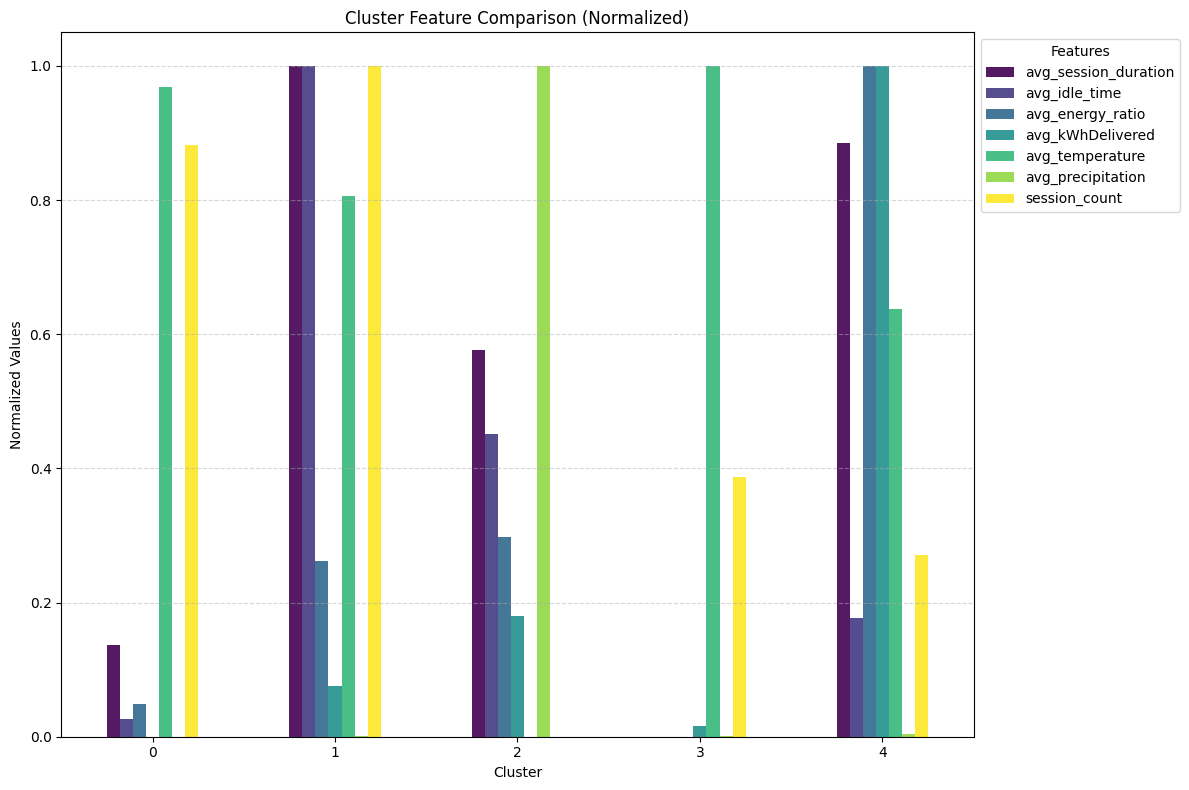

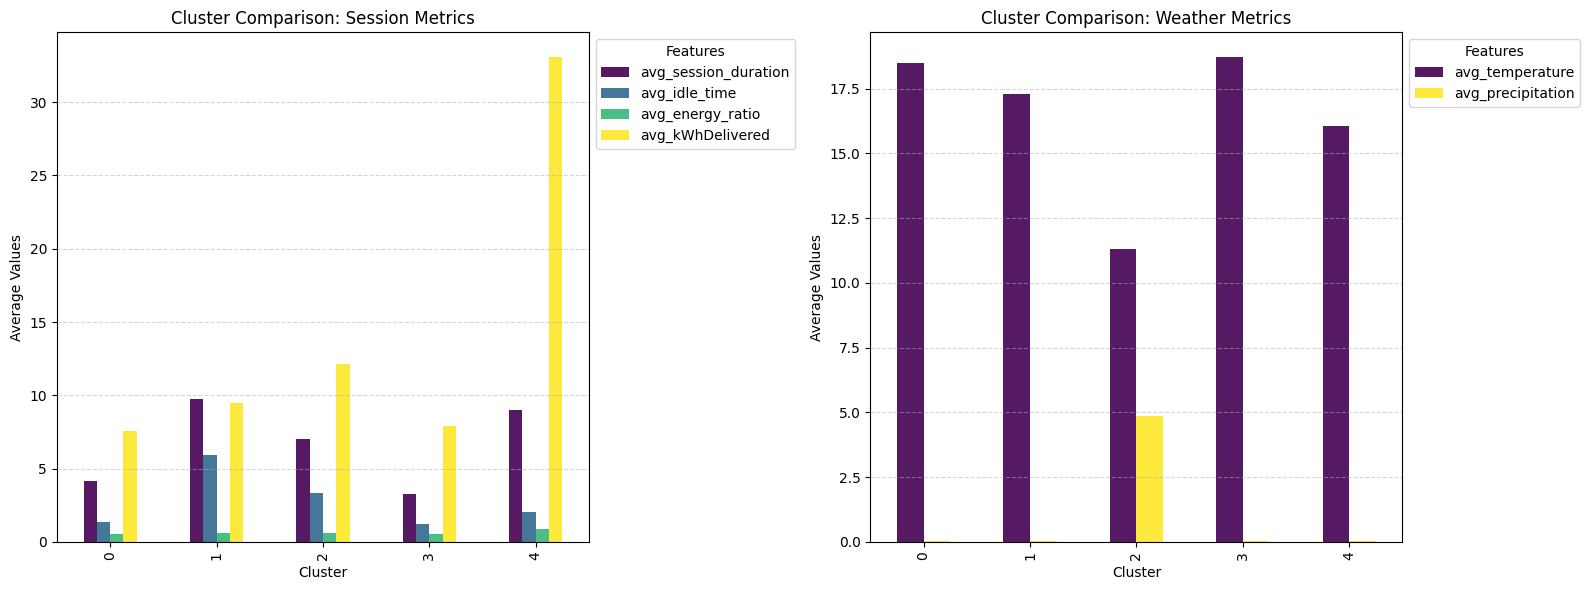

In [36]:
# Normalize data for meaningful comparison
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(cluster_summary)

# Convert to DataFrame for better handling
normalized_df = pd.DataFrame(
    normalized_data,
    columns=cluster_summary.columns,
    index=cluster_summary.index
)

# Plot the normalized data
plt.figure(figsize=(12, 8))
normalized_df.plot(kind="bar", figsize=(12, 8), colormap="viridis", alpha=0.9)
plt.title("Cluster Feature Comparison (Normalized)")
plt.xlabel("Cluster")
plt.ylabel("Normalized Values")
plt.xticks(rotation=0)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Features")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Separate Subplots for Session and Weather Metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Session metrics
cluster_summary[["avg_session_duration", "avg_idle_time", "avg_energy_ratio", "avg_kWhDelivered"]].plot(
    kind="bar", ax=axes[0], colormap="viridis", alpha=0.9
)
axes[0].set_title("Cluster Comparison: Session Metrics")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Average Values")
axes[0].legend(loc="upper left", bbox_to_anchor=(1, 1), title="Features")
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# Weather metrics
cluster_summary[["avg_temperature", "avg_precipitation"]].plot(
    kind="bar", ax=axes[1], colormap="viridis", alpha=0.9
)
axes[1].set_title("Cluster Comparison: Weather Metrics")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Average Values")
axes[1].legend(loc="upper left", bbox_to_anchor=(1, 1), title="Features")
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

This bar chart compares several normalized features (including average session duration, idle time, kWh delivered, temperature, precipitation, and session count) across the clusters. For instance, Cluster 1 shows particularly high values for session duration and idle time, whereas Cluster 0 stands out with a very high session count. Other groups, such as Cluster 3, rank low on almost all features, and Clusters 2 and 4 exhibit more mixed profiles. Overall, the chart highlights how these clusters differ across key metrics.

The chart on the left compares average session metrics (e.g., duration, idle time, and kWh delivered) by cluster, while the right plot highlights average temperature and precipitation. Notably, Cluster 4 stands out with the highest kWh delivered, whereas Cluster 3 remains low across most session metrics. For the weather factors, Cluster 2 appears to have a lower average temperature, whereas Cluster 3 shows relatively higher values.